<a href="https://colab.research.google.com/github/Craniace/Image-Processing/blob/main/lnn_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# prompt: pip install --upgrade torch torchvision torchaudio

!pip install --upgrade torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 954.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Load and preprocess the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data to add a time-step dimension
X_tensor = torch.FloatTensor(X_scaled).unsqueeze(1)  # Adding time-step dimension
y_tensor = torch.LongTensor(y)


In [3]:
class LTCCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LTCCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.bias_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(hidden_size))
        self.tau = nn.Parameter(torch.ones(hidden_size) * 1.0)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight_ih)
        nn.init.kaiming_uniform_(self.weight_hh)
        nn.init.constant_(self.bias_ih, 0)
        nn.init.constant_(self.bias_hh, 0)

    def forward(self, input, hidden):
        pre_activation = torch.addmm(self.bias_ih, input, self.weight_ih.t()) + torch.addmm(self.bias_hh, hidden, self.weight_hh.t())
        dh = (pre_activation - hidden) / self.tau
        new_hidden = hidden + dh
        return new_hidden

class LTCNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LTCNetwork, self).__init__()
        self.ltc_cell = LTCCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        hidden = torch.zeros(input.size(0), self.ltc_cell.hidden_size)
        for i in range(input.size(1)):
            hidden = self.ltc_cell(input[:, i, :], hidden)
        output = self.fc(hidden)
        return output, hidden


In [4]:
# Classification in a loop to calculate average accuracy
total_accuracy = 0
num_iterations = 5
for it in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=it)
    model = LTCNetwork(4, 10, 3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    for epoch in range(100):
        optimizer.zero_grad()
        outputs, _ = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    outputs, _ = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    total_accuracy += accuracy
    print(f'Iteration {it+1}')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predicted))
    print('Classification Report:')
    print(classification_report(y_test, predicted))

average_accuracy = total_accuracy / num_iterations
print(f'Average Test Accuracy: {average_accuracy:.2f}')


Iteration 1
Confusion Matrix:
[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

Iteration 2
Confusion Matrix:
[[14  0  0]
 [ 0 17  1]
 [ 0  0 13]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        18
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

Iteration 3
Confusion Matrix:
[[17  0  0]
 [ 0 15  0]
 [ 0

Silhouette Score: 0.50896454


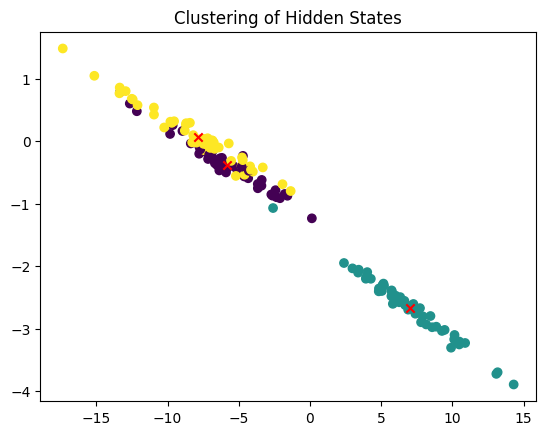

In [5]:
# Clustering with KMeans on hidden states
_, hidden_states = model(X_tensor)
hidden_states = hidden_states.detach().numpy()
kmeans = KMeans(n_clusters=3, random_state=42).fit(hidden_states)
print('Silhouette Score:', silhouette_score(hidden_states, kmeans.labels_))
plt.scatter(hidden_states[:, 0], hidden_states[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.title('Clustering of Hidden States')
plt.show()

In [6]:
# Regression (predicting the sepal length from other features)
model = LTCNetwork(4, 10, 1)  # Adjust output size for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# New target for regression: Sepal Length
y_reg = torch.FloatTensor(X[:, 0])  # Sepal length is the first feature

In [7]:
# Train the model for regression
for epoch in range(100):
    optimizer.zero_grad()
    outputs, _ = model(X_tensor[:, 1:])  # Use other features as input
    loss = criterion(outputs.squeeze(), y_reg)
    loss.backward()
    optimizer.step()

# Evaluate the regression
outputs, _ = model(X_tensor[:, 1:])
mse = mean_squared_error(y_reg.numpy(), outputs.detach().squeeze().numpy())
correlation = np.corrcoef(y_reg.numpy(), outputs.detach().squeeze().numpy())[0, 1]
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 21.62
